###### DATASETS & DATALOADERS

In order to keep our dataset code decoupled from our model training code (readibility and modularity), Pytorch provides 2 data primitives <code>torch.utils.data.DataLoader</code> and <code>torch.utils.data.Dataset</code>
    
<code>Dataset</code> stores samples and corresponding labels.

<code>DataLoader</code> wraps an iterator around <code>Dataset</code> for easy access.

Pytorch provides pre-loaded datasets that subclass <code>torch.utils.data.Dataset</code>:<br>
    <ul>
    <li>[Image Datasets](https://pytorch.org/vision/stable/datasets.html);</li>
    <li>[Text Datasets](https://pytorch.org/text/stable/datasets.html);</li>
    <li>[Audio Datasets](https://pytorch.org/audio/stable/datasets.html);</li>
    </ul>

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

###### Loading a Dataset

[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.



In [2]:
# root  is the path where train/test data is stored
# train specifies training or test data (True/False)
# download=True downloads the data from the internet if not available at root
# transform and target_transform specify the feature and label transformations

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

0.0%

11.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

39.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

90.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



119.3%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw




/home/akorra/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


##### Iterating and Visualizing the Dataset

Datasets can be indexed like lists: <code>training_data[index]</code>

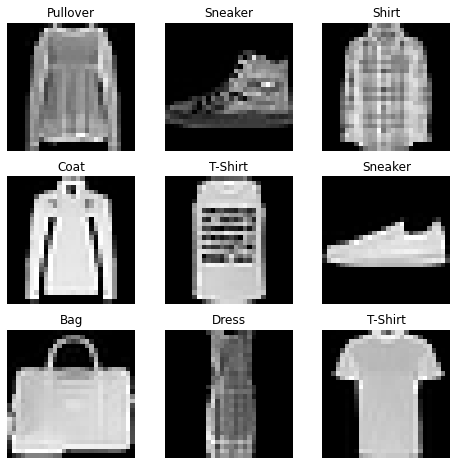

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot", 
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

###### Creating a Custom Dataset for our Files

A custom Dataset class must implement three functions: <code>\_\_init\_\_</code>, <code>\_\_len\_\_</code>, and <code>\_\_getitem\_\_</code>.

FashinMNIST images are stored in <code>img_dir</code>, with labels stored separately in a CSV file <code>annotations_file</code>

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

In [8]:
class CustomImageDataset(Dataset):
    # runs once on instantiation, in this case, we intitalize both directories and transforms
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # returns number of samples in dataset
    def __len__(self):
        return len(self.img_labels)

    # loads and returns a sample from the dataset at the given index idx
    def __getitem__(self, idx):        
        #identifies the image’s location on disk, converts that to a tensor using read_image, 
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        
        #retrieves the corresponding label from the csv data in self.img_labels, 
        label = self.img_labels.iloc[idx, 1]
        
        #calls the transform functions on them (if applicable)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        #and returns the tensor image and corresponding label in a tuple
        return image, label

###### Preparing your data for training with DataLoaders

<code>Dataset</code> retrieves its features and labels one sample at a time. While training, we typically want to pass samples in "minibatches" and reshuffle every epoch (reduce overfitting), and use Python's multiprocessing to speed up data retrieval.

<code>DataLoader</code> is an iterable that abstracts this complexity for us in an easy API.

In [9]:
from torch.utils.data import DataLoader

In [10]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data,     batch_size=64, shuffle=True)

###### Iterate through the DataLoader

We have loaded that dataset into the <code>DataLoader</code> and can iterate through the dataset as needed. Each iteration below returns a batch of <code>train_features</code> and <code>train_labels</code> (containing <code>batch_size=64</code> features and labels respectively). Because we specified <code>shuffle=True</code>, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


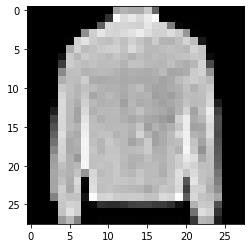

Label: 4


In [14]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")